## BayesSearchCV
- skopt
- pip3 install scikit-optimize

BayesSearchCV implements a "fit" and a "score" method. It also implements "predict", "predict_proba", "decision_function", "transform" and "inverse_transform" if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.(n_iter!)

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

In [27]:
%config InlineBackend.figure_format = 'retina'

In [2]:
ITERATIONS = 10 # 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000

# Load data
X = pd.read_csv(
    './data/train_sample.csv', 
    nrows=TRAINING_SIZE,
    parse_dates=['click_time']
)

# Split into X and y
y = X['is_attributed']
X = X.drop(['click_time','is_attributed', 'attributed_time'], axis=1)

## XGBoost

In [8]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [9]:
xgb_result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.9279
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.0005266983003701547, 'reg_lambda': 276.5424475574225, 'scale_pos_weight': 0.3016410771843142, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.9279
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'lea

In [11]:
xgb_result.best_score_

0.9437820084781707

In [10]:
xgb_result.best_params_

{'colsample_bylevel': 0.7366877378057127,
 'colsample_bytree': 0.9399760402267441,
 'gamma': 2.6498051478267012e-08,
 'learning_rate': 0.0238149998729586,
 'max_delta_step': 16,
 'max_depth': 19,
 'min_child_weight': 2,
 'n_estimators': 77,
 'reg_alpha': 0.011683028450342707,
 'reg_lambda': 0.0048879464985534336,
 'scale_pos_weight': 0.13267482411031659,
 'subsample': 0.5689543694097536}

In [17]:
xgb_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7366877378057127,
       colsample_bytree=0.9399760402267441, eval_metric='auc',
       gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586,
       max_delta_step=16, max_depth=19, min_child_weight=2, missing=None,
       n_estimators=77, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0,
       reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336,
       scale_pos_weight=0.13267482411031659, seed=None, silent=1,
       subsample=0.5689543694097536, tree_method='approx')

In [18]:
new_model = xgb_result.best_estimator_

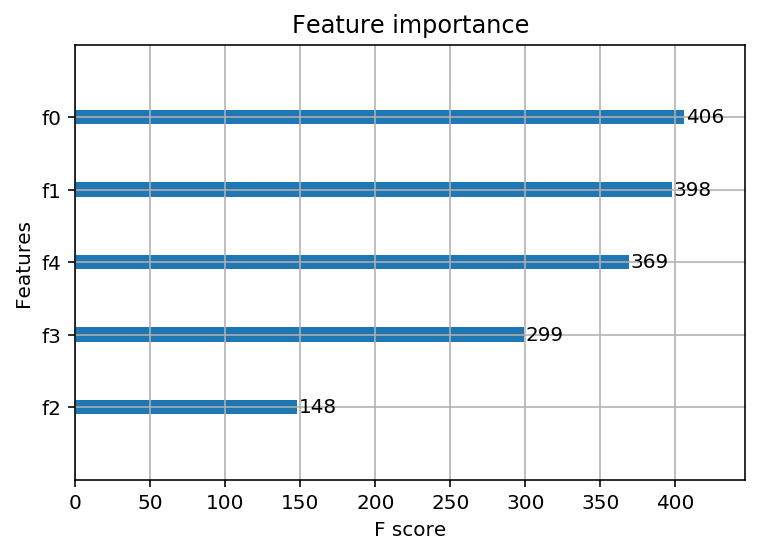

In [33]:
xgb.plot_importance(new_model);

In [15]:
xgb_result.cv_results_

defaultdict(list,
            {'split0_test_score': [0.5,
              0.942736769309165,
              0.9036215267557312,
              0.7664768429281755,
              0.9149290554548015,
              0.9508199056182765,
              0.970266156777475,
              0.5,
              0.9619782814423754,
              0.8688657418397158],
             'split1_test_score': [0.5,
              0.9204035989757906,
              0.9202405990169361,
              0.8314109624593686,
              0.8862962532164799,
              0.9419943677975383,
              0.9252757943478577,
              0.5,
              0.9345857822890258,
              0.9155486135508354],
             'split2_test_score': [0.5,
              0.9205941606278379,
              0.8919333273195618,
              0.7698788225035331,
              0.8939457357348328,
              0.9385314369907087,
              0.933384249932345,
              0.5,
              0.9272590231630433,
              0.88507602

## LightGBM

In [34]:
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'num_leaves': (1, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'subsample': (0.01, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'subsample_for_bin': (100000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 100),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

# Fit the model
lgbm_result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.4160029192647807, 'learning_rate': 0.28539836866041823, 'max_bin': 940, 'max_depth': 16, 'min_child_samples': 34, 'min_child_weight': 4, 'n_estimators': 68, 'num_leaves': 74, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216, 'subsample_for_bin': 171234, 'subsample_freq': 6}

Model #2
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.4160029192647807, 'learning_rate': 0.28539836866041823, 'max_bin': 940, 'max_depth': 16, 'min_child_samples': 34, 'min_child_weight': 4, 'n_estimators': 68, 'num_leaves': 74, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216, 'subsample_for_bin': 171234, 'subsample_freq': 6}

Model #3
Best ROC-AUC: 0.5108
Best params: {'colsample_bytree': 0.4503841871781403, 'learning_rate': 0.6877728743793542, 'max_bi

In [36]:
lgbm_result.best_params_

{'colsample_bytree': 0.6209085649172932,
 'learning_rate': 0.35540927532494104,
 'max_bin': 423,
 'max_depth': 44,
 'min_child_samples': 30,
 'min_child_weight': 6,
 'n_estimators': 82,
 'num_leaves': 43,
 'reg_alpha': 0.004026635957416632,
 'reg_lambda': 0.040887904512512056,
 'scale_pos_weight': 109.72255122430063,
 'subsample': 0.6612742297240571,
 'subsample_for_bin': 344698,
 'subsample_freq': 3}

In [37]:
lgbm_result.estimator

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='auc', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=1, num_leaves=31, objective='binary', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1, verbose=0)